### 1. Import Library yang dibutuhkan

In [1]:
# Untuk manipulasi data
import pandas as pd
import numpy as np

# Untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk preprocessing data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Untuk modeling
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

# Untuk evaluasi model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

### 2. Load Dataset

In [2]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Path ke file CSV di dalam folder 'dataset'
ford_path = '/content/drive/MyDrive/dataset/ford.csv'
hyundai_path = '/content/drive/MyDrive/dataset/hyundai.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 3. Penggabungan Data

In [3]:
# Baca data (ambil 4000 baris pertama)
ford = pd.read_csv(ford_path).head(4000)
hyundai = pd.read_csv(hyundai_path).head(4000)

# Tambahkan kolom brand
ford['brand'] = 'ford'
hyundai['brand'] = 'hyundai'

# Gabungkan kedua dataset
combined_data = pd.concat([ford, hyundai], ignore_index=True)

# Hapus kolom terakhir (tax yang NaN)
combined_data = combined_data.iloc[:, :-1]

# Batasi nilai kolom 'tax' menjadi 3 digit tanpa desimal
combined_data['tax'] = combined_data['tax'].astype('Int64')  # atau pakai .fillna(0).astype(int) jika ingin menghapus NaN

# Verifikasi kolom
print("Daftar kolom:", combined_data.columns.tolist())
print("Jumlah kolom:", len(combined_data.columns))

# Cetak 5 baris pertama (tanpa index)
print("\n5 data pertama:")
print(combined_data.head().to_string(index=False))

Daftar kolom: ['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg', 'engineSize', 'brand']
Jumlah kolom: 10

5 data pertama:
  model  year  price transmission  mileage fuelType  tax  mpg  engineSize brand
 Fiesta  2017  12000    Automatic    15944   Petrol  150 57.7         1.0  ford
  Focus  2018  14000       Manual     9083   Petrol  150 57.7         1.0  ford
  Focus  2017  13000       Manual    12456   Petrol  150 57.7         1.0  ford
 Fiesta  2019  17500       Manual    10460   Petrol  145 40.3         1.5  ford
 Fiesta  2019  16500    Automatic     1482   Petrol  145 48.7         1.0  ford


### 4. Visualisasi Data (Korelasi Data Numerik)

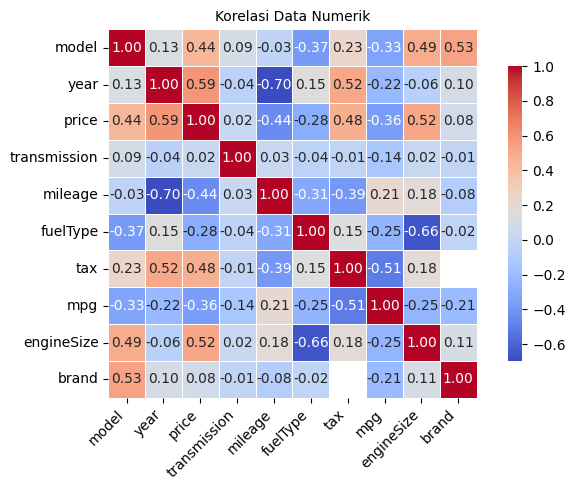

In [4]:
# Ubah kolom kategorikal menjadi numerik dengan Label Encoding
from sklearn.preprocessing import LabelEncoder

# Salin data agar tidak mengubah aslinya
data_corr = combined_data.copy()

# Kolom kategorikal yang ingin dikonversi
cat_cols = ['model', 'transmission', 'fuelType', 'brand']
le = LabelEncoder()
for col in cat_cols:
    data_corr[col] = le.fit_transform(data_corr[col].astype(str))

# Daftar 10 kolom yang diinginkan
selected_cols = ['model', 'year', 'price', 'transmission', 'mileage',
                 'fuelType', 'tax', 'mpg', 'engineSize', 'brand']

# Pastikan semua kolom bisa dihitung korelasinya
data_corr[selected_cols] = data_corr[selected_cols].apply(pd.to_numeric, errors='coerce')

# Plot heatmap korelasi
plt.figure(figsize=(7, 5))  # Ukuran kecil
sns.heatmap(
    data_corr[selected_cols].corr(),
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Korelasi Data Numerik", fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 5. Data Cleaning

In [5]:
print("Missing values sebelum cleaning:")
print(combined_data.isnull().sum())

# Dapatkan daftar kolom numerik dan kategorikal
numeric_cols = combined_data.select_dtypes(include=['number']).columns
categorical_cols = combined_data.select_dtypes(include=['object']).columns

# Isi missing values untuk kolom numerik dengan median
for col in numeric_cols:
    combined_data[col] = combined_data[col].fillna(combined_data[col].median())

# Isi missing values untuk kolom kategorikal dengan modus
for col in categorical_cols:
    combined_data[col] = combined_data[col].fillna(combined_data[col].mode()[0])

print("\nMissing values setelah cleaning:")
print(combined_data.isnull().sum())

Missing values sebelum cleaning:
model              0
year               0
price              0
transmission       0
mileage            0
fuelType           0
tax             4000
mpg                0
engineSize         0
brand              0
dtype: int64

Missing values setelah cleaning:
model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
brand           0
dtype: int64


### 6. Data Preparation (Pemilihan fitur dan target)

In [6]:
# Memisahkan fitur dan target
X = combined_data.drop(['price'], axis=1)  # Semua kolom kecuali 'price' dijadikan fitur
y = combined_data['price']  # Kolom 'price' dijadikan target

# Menampilkan informasi tentang fitur dan target
print("\nFitur (X):", X.columns.tolist())  # Menampilkan nama kolom fitur
print("Target (y): price")  # Menampilkan target yang digunakan


Fitur (X): ['model', 'year', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg', 'engineSize', 'brand']
Target (y): price


### 7. Pembagian Data Training dan Testing

In [7]:
from sklearn.model_selection import train_test_split

# Pembagian data 90:10
X_train_90, X_test_10, y_train_90, y_test_10 = train_test_split(X, y, test_size=0.1, random_state=42)

# Menampilkan ukuran data
print("Pembagian 90:10")
print("Training:", X_train_90.shape)
print("Testing :", X_test_10.shape)

# Menyimpan ke dalam dictionary (jika diperlukan)
splits = {}
splits['train_90_test_10'] = {
    'X_train': X_train_90, 'X_test': X_test_10,
    'y_train': y_train_90, 'y_test': y_test_10
}

Pembagian 90:10
Training: (7200, 9)
Testing : (800, 9)


In [8]:
# Pembagian data 80:20
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X, y, test_size=0.2, random_state=42)

# Menampilkan ukuran data
print("\nPembagian 80:20")
print("Training:", X_train_80.shape)
print("Testing :", X_test_20.shape)

# Menyimpan ke dalam dictionary (jika diperlukan)
splits['train_80_test_20'] = {
    'X_train': X_train_80, 'X_test': X_test_20,
    'y_train': y_train_80, 'y_test': y_test_20
}


Pembagian 80:20
Training: (6400, 9)
Testing : (1600, 9)


In [9]:
# Pembagian data 70:30
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(X, y, test_size=0.3, random_state=42)

# Menampilkan ukuran data
print("\nPembagian 70:30")
print("Training:", X_train_70.shape)
print("Testing :", X_test_30.shape)

# Menyimpan ke dalam dictionary (jika diperlukan)
splits['train_70_test_30'] = {
    'X_train': X_train_70, 'X_test': X_test_30,
    'y_train': y_train_70, 'y_test': y_test_30
}


Pembagian 70:30
Training: (5600, 9)
Testing : (2400, 9)


In [10]:
# Pembagian data 60:40
X_train_60, X_test_40, y_train_60, y_test_40 = train_test_split(X, y, test_size=0.4, random_state=42)

# Menampilkan ukuran data
print("\nPembagian 60:40")
print("Training:", X_train_60.shape)
print("Testing :", X_test_40.shape)

# Menyimpan ke dalam dictionary (jika diperlukan)
splits['train_60_test_40'] = {
    'X_train': X_train_60, 'X_test': X_test_40,
    'y_train': y_train_60, 'y_test': y_test_40
}


Pembagian 60:40
Training: (4800, 9)
Testing : (3200, 9)


In [11]:
# Pembagian data 50:50
X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(X, y, test_size=0.5, random_state=42)

# Menampilkan ukuran data
print("\nPembagian 50:50")
print("Training:", X_train_50.shape)
print("Testing :", X_test_50.shape)

# Menyimpan ke dalam dictionary (jika diperlukan)
splits['train_50_test_50'] = {
    'X_train': X_train_50, 'X_test': X_test_50,
    'y_train': y_train_50, 'y_test': y_test_50
}


Pembagian 50:50
Training: (4000, 9)
Testing : (4000, 9)


### 8. Identifikasi Kolom Kategorikal

In [12]:
from sklearn.model_selection import train_test_split

# Daftar rasio test_size
ratios = [0.1, 0.2, 0.3, 0.4, 0.5]

# Dictionary untuk menyimpan hasil pembagian
splits = {}

# List untuk menyimpan hasil kolom kategorikal
categorical_columns_summary = []

# Loop untuk pembagian data dan identifikasi kolom kategorikal
for ratio in ratios:
    # Membagi data
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=42)

    # Identifikasi kolom kategorikal
    categorical_cols = X_train_raw.select_dtypes(include=['object']).columns

    # Menyimpan hasil kolom kategorikal
    categorical_columns_summary.append(
        f"Kolom kategorikal yang akan diencoding untuk rasio {int((1-ratio)*100)}:{int(ratio*100)}: {list(categorical_cols)}"
    )

    # Menyimpan hasil pembagian data ke dalam dictionary
    splits[f'train_{int((1-ratio)*100)}_test_{int(ratio*100)}'] = {
        'X_train': X_train_raw, 'X_test': X_test_raw,
        'y_train': y_train, 'y_test': y_test,
        'categorical_cols': list(categorical_cols)
    }

# Output hasil kolom kategorikal
print("\n".join(categorical_columns_summary))

Kolom kategorikal yang akan diencoding untuk rasio 90:10: ['model', 'transmission', 'fuelType', 'brand']
Kolom kategorikal yang akan diencoding untuk rasio 80:20: ['model', 'transmission', 'fuelType', 'brand']
Kolom kategorikal yang akan diencoding untuk rasio 70:30: ['model', 'transmission', 'fuelType', 'brand']
Kolom kategorikal yang akan diencoding untuk rasio 60:40: ['model', 'transmission', 'fuelType', 'brand']
Kolom kategorikal yang akan diencoding untuk rasio 50:50: ['model', 'transmission', 'fuelType', 'brand']


### 9. Label Encoding untuk Kategorikal

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# List rasio test_size
ratios = [0.1, 0.2, 0.3, 0.4, 0.5]

# Dictionary untuk menyimpan hasil pembagian dan encoding
splits = {}
encoders = {}

# Manual list kolom kategorikal (pastikan ini sesuai dengan dataset asli kamu)
categorical_cols = ['model', 'transmission', 'fuelType', 'brand']

for ratio in ratios:
    # Split data
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=42)

    # Copy dataframe agar aman (hindari SettingWithCopyWarning)
    X_train_raw = X_train_raw.copy()
    X_test_raw = X_test_raw.copy()

    # Simpan encoder untuk rasio ini
    encoders[ratio] = {}

    # Encode semua kolom kategorikal yang sudah didefinisikan manual
    for col in categorical_cols:
        le = LabelEncoder()
        # Bersihkan spasi dulu, baru fit_transform
        X_train_raw[col] = X_train_raw[col].astype(str).str.strip()
        X_train_raw[col] = le.fit_transform(X_train_raw[col])

        X_test_raw[col] = X_test_raw[col].astype(str).str.strip()
        X_test_raw[col] = le.transform(X_test_raw[col])

        encoders[ratio][col] = le

    # Simpan hasil split dan encoding
    splits[f'train_{int((1-ratio)*100)}_test_{int(ratio*100)}'] = {
        'X_train': X_train_raw, 'X_test': X_test_raw,
        'y_train': y_train, 'y_test': y_test,
        'categorical_cols': categorical_cols
    }

    # Tampilkan hasil encoding semua kolom kategorikal
    print(f"\nRasio test_size={ratio}:")
    for col in categorical_cols:
        print(f"Kolom '{col}' 5 sampel encoding (train):")
        print(X_train_raw[col].head())
    print("-" * 50)


Rasio test_size=0.1:
Kolom 'model' 5 sampel encoding (train):
7935     9
4608     9
2939    20
4336    11
3658     4
Name: model, dtype: int64
Kolom 'transmission' 5 sampel encoding (train):
7935    2
4608    1
2939    1
4336    1
3658    1
Name: transmission, dtype: int64
Kolom 'fuelType' 5 sampel encoding (train):
7935    2
4608    2
2939    0
4336    0
3658    2
Name: fuelType, dtype: int64
Kolom 'brand' 5 sampel encoding (train):
7935    1
4608    1
2939    0
4336    1
3658    0
Name: brand, dtype: int64
--------------------------------------------------

Rasio test_size=0.2:
Kolom 'model' 5 sampel encoding (train):
1467     4
5768    16
5714    10
1578     4
6958     9
Name: model, dtype: int64
Kolom 'transmission' 5 sampel encoding (train):
1467    1
5768    0
5714    1
1578    1
6958    1
Name: transmission, dtype: int64
Kolom 'fuelType' 5 sampel encoding (train):
1467    2
5768    1
5714    2
1578    2
6958    2
Name: fuelType, dtype: int64
Kolom 'brand' 5 sampel encoding (tra

In [14]:
# Memeriksa apakah data tersimpan di splits
print("\nMemeriksa data yang disimpan di splits:\n")

# Loop untuk menampilkan informasi tentang setiap pembagian
for key, value in splits.items():
    # Ganti format key pembagian agar lebih ringkas (misalnya train_50_test_50 menjadi 50:50)
    key_display = key.replace('train_', '').replace('test_', '').replace('_', ':')

    print(f"Pembagian: {key_display}")
    print(f"Ukuran X_train: {value['X_train'].shape}")
    print(f"Ukuran X_test: {value['X_test'].shape}")
    print(f"Ukuran y_train: {value['y_train'].shape}")
    print(f"Ukuran y_test: {value['y_test'].shape}")
    print(f"Kolom kategorikal yang diencoding: {value['categorical_cols']}")
    print("-" * 50)  # Memisahkan setiap pembagian


Memeriksa data yang disimpan di splits:

Pembagian: 90:10
Ukuran X_train: (7200, 9)
Ukuran X_test: (800, 9)
Ukuran y_train: (7200,)
Ukuran y_test: (800,)
Kolom kategorikal yang diencoding: ['model', 'transmission', 'fuelType', 'brand']
--------------------------------------------------
Pembagian: 80:20
Ukuran X_train: (6400, 9)
Ukuran X_test: (1600, 9)
Ukuran y_train: (6400,)
Ukuran y_test: (1600,)
Kolom kategorikal yang diencoding: ['model', 'transmission', 'fuelType', 'brand']
--------------------------------------------------
Pembagian: 70:30
Ukuran X_train: (5600, 9)
Ukuran X_test: (2400, 9)
Ukuran y_train: (5600,)
Ukuran y_test: (2400,)
Kolom kategorikal yang diencoding: ['model', 'transmission', 'fuelType', 'brand']
--------------------------------------------------
Pembagian: 60:40
Ukuran X_train: (4800, 9)
Ukuran X_test: (3200, 9)
Ukuran y_train: (4800,)
Ukuran y_test: (3200,)
Kolom kategorikal yang diencoding: ['model', 'transmission', 'fuelType', 'brand']
-------------------

### 10. Pelatihan Model (Desicion Tree)

In [15]:
from sklearn.tree import DecisionTreeRegressor

# Dictionary untuk menyimpan model Decision Tree
decision_tree_models = {}

# Melatih model Decision Tree untuk semua rasio
for ratio, data in splits.items():
    X_train = data['X_train']
    y_train = data['y_train']

    # Inisialisasi dan latih model Decision Tree dengan pembatasan agar tidak overfitting
    model_dt = DecisionTreeRegressor(
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    )
    model_dt.fit(X_train, y_train)

    # Simpan model ke dictionary dan juga ke dalam struktur data splits
    decision_tree_models[ratio] = model_dt
    splits[ratio]['model_dt'] = model_dt

### 11. Evaluasi (Decision Tree)

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Dictionary untuk menyimpan hasil evaluasi
results_dt = {}

# Mapping nama key lama ke format baru (jika belum dilakukan)
key_mapping = {
    "train_90_test_10": "(90:10)",
    "train_80_test_20": "(80:20)",
    "train_70_test_30": "(70:30)",
    "train_60_test_40": "(60:40)",
    "train_50_test_50": "(50:50)"
}

# Perbarui key jika belum pakai format baru
if not list(splits.keys())[0].startswith('('):
    splits = {key_mapping[k]: v for k, v in splits.items()}

# Evaluasi model Decision Tree untuk semua rasio
for ratio, data in splits.items():
    model = data['model_dt']  # ambil model Decision Tree
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']

    # Prediksi
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Rata-rata target (untuk konversi ke persen)
    y_train_mean = np.mean(y_train)
    y_test_mean = np.mean(y_test)

    # MAE & RMSE dalam persen
    mae_train = mean_absolute_error(y_train, y_pred_train) / y_train_mean * 100
    mae_test = mean_absolute_error(y_test, y_pred_test) / y_test_mean * 100

    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train)) / y_train_mean * 100
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test)) / y_test_mean * 100

    # MAPE dalam persen
    mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

    # Simpan hasil evaluasi
    results_dt[ratio] = {
        'MAE_Train': round(mae_train, 2),
        'MAE_Test': round(mae_test, 2),
        'RMSE_Train': round(rmse_train, 2),
        'RMSE_Test': round(rmse_test, 2),
        'MAPE_Train': round(mape_train, 2),
        'MAPE_Test': round(mape_test, 2)
    }

    # Cetak hasil evaluasi
    print(f"\nDecision Tree - Evaluasi untuk rasio {ratio}:")
    print(f"MAE Train: {results_dt[ratio]['MAE_Train']}% | MAE Test: {results_dt[ratio]['MAE_Test']}%")
    print(f"RMSE Train: {results_dt[ratio]['RMSE_Train']}% | RMSE Test: {results_dt[ratio]['RMSE_Test']}%")
    print(f"MAPE Train: {results_dt[ratio]['MAPE_Train']}% | MAPE Test: {results_dt[ratio]['MAPE_Test']}%")
    print("-" * 60)


Decision Tree - Evaluasi untuk rasio (90:10):
MAE Train: 6.62% | MAE Test: 8.23%
RMSE Train: 9.58% | RMSE Test: 11.9%
MAPE Train: 6.8% | MAPE Test: 8.39%
------------------------------------------------------------

Decision Tree - Evaluasi untuk rasio (80:20):
MAE Train: 6.62% | MAE Test: 8.15%
RMSE Train: 9.54% | RMSE Test: 11.85%
MAPE Train: 6.81% | MAPE Test: 8.29%
------------------------------------------------------------

Decision Tree - Evaluasi untuk rasio (70:30):
MAE Train: 6.58% | MAE Test: 8.24%
RMSE Train: 9.28% | RMSE Test: 12.3%
MAPE Train: 6.74% | MAPE Test: 8.34%
------------------------------------------------------------

Decision Tree - Evaluasi untuk rasio (60:40):
MAE Train: 6.6% | MAE Test: 8.4%
RMSE Train: 9.26% | RMSE Test: 12.25%
MAPE Train: 6.77% | MAPE Test: 8.51%
------------------------------------------------------------

Decision Tree - Evaluasi untuk rasio (50:50):
MAE Train: 6.58% | MAE Test: 8.3%
RMSE Train: 9.31% | RMSE Test: 11.94%
MAPE Train: 6.

### 12. Visualisasi Model (Decision Tree)

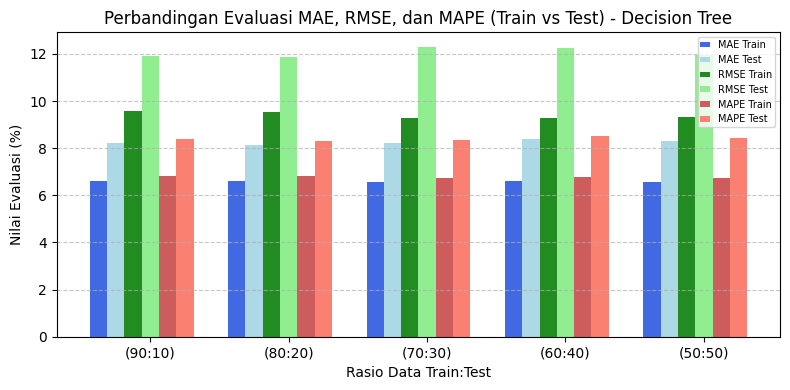

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Ambil label rasio
labels = list(results_dt.keys())
x = np.arange(len(labels))  # posisi bar di sumbu x
width = 0.25  # lebar bar

# Ambil data dari results_dt
mae_train = [results_dt[k]['MAE_Train'] for k in labels]
mae_test = [results_dt[k]['MAE_Test'] for k in labels]
rmse_train = [results_dt[k]['RMSE_Train'] for k in labels]
rmse_test = [results_dt[k]['RMSE_Test'] for k in labels]
mape_train = [results_dt[k]['MAPE_Train'] for k in labels]
mape_test = [results_dt[k]['MAPE_Test'] for k in labels]

# Buat figure yang sedikit lebih besar
plt.figure(figsize=(8, 4))

# Plot MAE
plt.bar(x - width, mae_train, width=width/2, label='MAE Train', color='royalblue')
plt.bar(x - width/2, mae_test, width=width/2, label='MAE Test', color='lightblue')

# Plot RMSE
plt.bar(x, rmse_train, width=width/2, label='RMSE Train', color='forestgreen')
plt.bar(x + width/2, rmse_test, width=width/2, label='RMSE Test', color='lightgreen')

# Plot MAPE
plt.bar(x + width, mape_train, width=width/2, label='MAPE Train', color='indianred')
plt.bar(x + 1.5 * width, mape_test, width=width/2, label='MAPE Test', color='salmon')

# Label dan legenda
plt.xticks(x + width / 2, labels)
plt.xlabel('Rasio Data Train:Test')
plt.ylabel('Nilai Evaluasi (%)')
plt.title('Perbandingan Evaluasi MAE, RMSE, dan MAPE (Train vs Test) - Decision Tree')
plt.legend(
    fontsize=7,
    markerscale=0.5,
    handlelength=1.0,
    handleheight=0.5,
    borderpad=0.3,
    loc='upper right'
)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 13. Pelatihan Model (Random Forest)

In [18]:
from sklearn.ensemble import RandomForestRegressor

# Dictionary untuk menyimpan model Random Forest
random_forest_models = {}

# Melatih model Random Forest untuk semua rasio
for ratio, data in splits.items():
    X_train = data['X_train']
    y_train = data['y_train']

    # Inisialisasi dan latih model Random Forest dengan pembatasan agar tidak overfitting
    model_rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    )
    model_rf.fit(X_train, y_train)

    # Simpan model ke dictionary dan juga ke dalam struktur data splits
    random_forest_models[ratio] = model_rf
    splits[ratio]['model_rf'] = model_rf

### 14. Evaluasi (Random Forest)

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Dictionary untuk menyimpan hasil evaluasi Random Forest
results_rf = {}

# Evaluasi untuk model Random Forest
for ratio, data in splits.items():
    model_rf = data['model_rf']  # Ambil model Random Forest
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']

    # Prediksi
    y_pred_train = model_rf.predict(X_train)
    y_pred_test = model_rf.predict(X_test)

    # Rata-rata target (digunakan untuk konversi ke persen)
    y_train_mean = np.mean(y_train)
    y_test_mean = np.mean(y_test)

    # MAE & RMSE dalam persen
    mae_train = mean_absolute_error(y_train, y_pred_train) / y_train_mean * 100
    mae_test = mean_absolute_error(y_test, y_pred_test) / y_test_mean * 100

    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train)) / y_train_mean * 100
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test)) / y_test_mean * 100

    # MAPE dalam persen
    mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

    results_rf[ratio] = {
        'MAE_Train': round(mae_train, 2),
        'MAE_Test': round(mae_test, 2),
        'RMSE_Train': round(rmse_train, 2),
        'RMSE_Test': round(rmse_test, 2),
        'MAPE_Train': round(mape_train, 2),
        'MAPE_Test': round(mape_test, 2)
    }

    # Cetak hasil evaluasi
    print(f"\nRandom Forest - Evaluasi untuk rasio {ratio}:")
    print(f"MAE Train: {results_rf[ratio]['MAE_Train']}% | MAE Test: {results_rf[ratio]['MAE_Test']}%")
    print(f"RMSE Train: {results_rf[ratio]['RMSE_Train']}% | RMSE Test: {results_rf[ratio]['RMSE_Test']}%")
    print(f"MAPE Train: {results_rf[ratio]['MAPE_Train']}% | MAPE Test: {results_rf[ratio]['MAPE_Test']}%")
    print("-" * 60)


Random Forest - Evaluasi untuk rasio (90:10):
MAE Train: 6.26% | MAE Test: 7.38%
RMSE Train: 9.06% | RMSE Test: 11.07%
MAPE Train: 6.39% | MAPE Test: 7.49%
------------------------------------------------------------

Random Forest - Evaluasi untuk rasio (80:20):
MAE Train: 6.23% | MAE Test: 7.38%
RMSE Train: 9.06% | RMSE Test: 10.81%
MAPE Train: 6.36% | MAPE Test: 7.43%
------------------------------------------------------------

Random Forest - Evaluasi untuk rasio (70:30):
MAE Train: 6.21% | MAE Test: 7.45%
RMSE Train: 8.85% | RMSE Test: 11.42%
MAPE Train: 6.34% | MAPE Test: 7.46%
------------------------------------------------------------

Random Forest - Evaluasi untuk rasio (60:40):
MAE Train: 6.17% | MAE Test: 7.42%
RMSE Train: 8.87% | RMSE Test: 11.08%
MAPE Train: 6.27% | MAPE Test: 7.46%
------------------------------------------------------------

Random Forest - Evaluasi untuk rasio (50:50):
MAE Train: 6.14% | MAE Test: 7.45%
RMSE Train: 8.95% | RMSE Test: 10.98%
MAPE Tra

### 15.Simpan Model Terbaik

In [20]:
import pickle

best_ratio = '(80:20)'
best_data = splits[best_ratio]
best_model = best_data['model_rf']

# Konversi key '(80:20)' → float 0.2
ratio_value = int(best_ratio.strip('()').split(':')[1]) / 100

# Ambil encoder dari struktur nested
best_encoders = {}
for col in best_data['categorical_cols']:
    best_encoders[col] = encoders[ratio_value][col]

# Simpan model dan encoder ke file
with open('best_random_forest_model.sav', 'wb') as model_file:
    pickle.dump(best_model, model_file)

with open('best_label_encoders.sav', 'wb') as encoder_file:
    pickle.dump(best_encoders, encoder_file)

print("✅ Model dan encoder berhasil disimpan ke file .sav")

# ===============================
# Tampilkan isi file .sav
# ===============================

# Load ulang model dan encoder
with open('best_random_forest_model.sav', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

with open('best_label_encoders.sav', 'rb') as encoder_file:
    loaded_encoders = pickle.load(encoder_file)

# Tampilkan informasi model
print("\n📦 Model yang dimuat:")
print(loaded_model)

# Tampilkan isi encoder
print("\n📦 Daftar kolom kategorikal dan label encoding-nya:")
for col, le in loaded_encoders.items():
    print(f"- Kolom '{col}':")
    print(f"  Classes: {list(le.classes_)}")

✅ Model dan encoder berhasil disimpan ke file .sav

📦 Model yang dimuat:
RandomForestRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=10,
                      random_state=42)

📦 Daftar kolom kategorikal dan label encoding-nya:
- Kolom 'model':
  Classes: ['B-MAX', 'C-MAX', 'EcoSport', 'Edge', 'Fiesta', 'Focus', 'Galaxy', 'Grand C-MAX', 'Grand Tourneo Connect', 'I10', 'I20', 'I30', 'I40', 'I800', 'IX20', 'IX35', 'Ioniq', 'KA', 'Ka+', 'Kona', 'Kuga', 'Mondeo', 'Mustang', 'Puma', 'S-MAX', 'Santa Fe', 'Tourneo Connect', 'Tourneo Custom', 'Tucson', 'Veloster']
- Kolom 'transmission':
  Classes: ['Automatic', 'Manual', 'Semi-Auto']
- Kolom 'fuelType':
  Classes: ['Diesel', 'Hybrid', 'Petrol']
- Kolom 'brand':
  Classes: ['ford', 'hyundai']


In [21]:
import pandas as pd

# Contoh input pengguna (misal dari Streamlit atau sumber lain)
input_raw = {
    'brand': 'ford',
    'model': 'Fiesta',
    'year': 2015,
    'transmission': 'Manual',
    'mileage': 30000 / 1.60934,  # konversi km ke miles
    'fuelType': 'Petrol',
    'tax': 200.0,  # Asumsikan sudah dalam pound
    'mpg': 50.0,
    'engineSize': 1.4  # pastikan key 'engineSize' sesuai kolom saat training
}

# Buat DataFrame dari input (harus list agar jadi 1 baris)
input_df = pd.DataFrame([input_raw])

# Kolom kategorikal yang digunakan saat training
categorical_cols = ['brand', 'model', 'transmission', 'fuelType']

# Ambil encoder sesuai rasio terbaik
best_ratio = 0.2
best_encoders = encoders[best_ratio]

# Bersihkan spasi & encode kolom kategorikal
for col in categorical_cols:
    input_df[col] = input_df[col].astype(str).str.strip()  # hapus spasi
    le = best_encoders[col]
    val = input_df.at[0, col]
    if val not in le.classes_:
        raise ValueError(f"❌ Nilai '{val}' tidak ditemukan di encoder kolom '{col}'.")
    input_df[col] = le.transform([val])  # transform harus pakai array/list

# Urutkan kolom input sesuai urutan fitur model saat training
feature_order = list(best_model.feature_names_in_)  # ambil urutan kolom dari model langsung
input_df = input_df[feature_order]

# Prediksi harga menggunakan model terbaik
predicted_price = best_model.predict(input_df)[0]

print(f"✅ Prediksi harga mobil: £{predicted_price:.2f}")

✅ Prediksi harga mobil: £7763.62


### 16. Visualisasi Model (Random Forest)

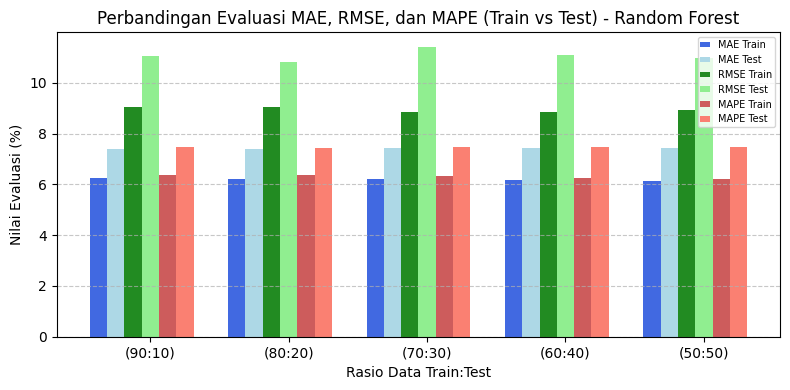

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Ambil label rasio
labels = list(results_rf.keys())
x = np.arange(len(labels))  # posisi bar di sumbu x
width = 0.25  # lebar bar

# Ambil data dari results_rf
mae_train = [results_rf[k]['MAE_Train'] for k in labels]
mae_test = [results_rf[k]['MAE_Test'] for k in labels]
rmse_train = [results_rf[k]['RMSE_Train'] for k in labels]
rmse_test = [results_rf[k]['RMSE_Test'] for k in labels]
mape_train = [results_rf[k]['MAPE_Train'] for k in labels]
mape_test = [results_rf[k]['MAPE_Test'] for k in labels]

# Buat figure yang sedikit lebih besar
plt.figure(figsize=(8, 4))

# Plot MAE
plt.bar(x - width, mae_train, width=width/2, label='MAE Train', color='royalblue')
plt.bar(x - width/2, mae_test, width=width/2, label='MAE Test', color='lightblue')

# Plot RMSE
plt.bar(x, rmse_train, width=width/2, label='RMSE Train', color='forestgreen')
plt.bar(x + width/2, rmse_test, width=width/2, label='RMSE Test', color='lightgreen')

# Plot MAPE
plt.bar(x + width, mape_train, width=width/2, label='MAPE Train', color='indianred')
plt.bar(x + 1.5 * width, mape_test, width=width/2, label='MAPE Test', color='salmon')

# Label dan legenda
plt.xticks(x + width / 2, labels)
plt.xlabel('Rasio Data Train:Test')
plt.ylabel('Nilai Evaluasi (%)')
plt.title('Perbandingan Evaluasi MAE, RMSE, dan MAPE (Train vs Test) - Random Forest')
plt.legend(
    fontsize=7,
    markerscale=0.5,
    handlelength=1.0,
    handleheight=0.5,
    borderpad=0.3,
    loc='upper right'
)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 17. R2 Score

In [23]:
from sklearn.metrics import r2_score

# Dictionary untuk menyimpan R2 score
r2_results_dt = {}
r2_results_rf = {}

# Menghitung R2 Score untuk Decision Tree dan Random Forest
for ratio, data in splits.items():
    X_test = data['X_test']
    y_test = data['y_test']

    # Ambil model Decision Tree dan Random Forest
    model_dt = data['model_dt']
    model_rf = data['model_rf']

    # Prediksi untuk Decision Tree
    y_pred_dt = model_dt.predict(X_test)
    r2_dt = r2_score(y_test, y_pred_dt) * 100  # R2 dalam persen
    r2_results_dt[ratio] = round(r2_dt, 2)

    # Prediksi untuk Random Forest
    y_pred_rf = model_rf.predict(X_test)
    r2_rf = r2_score(y_test, y_pred_rf) * 100  # R2 dalam persen
    r2_results_rf[ratio] = round(r2_rf, 2)

# Menampilkan R2 score
print("R2 Score untuk Decision Tree:")
for ratio in r2_results_dt:
    print(f"{ratio}: {r2_results_dt[ratio]}%")

print("\nR2 Score untuk Random Forest:")
for ratio in r2_results_rf:
    print(f"{ratio}: {r2_results_rf[ratio]}%")

R2 Score untuk Decision Tree:
(90:10): 91.72%
(80:20): 91.84%
(70:30): 91.25%
(60:40): 91.31%
(50:50): 91.65%

R2 Score untuk Random Forest:
(90:10): 92.84%
(80:20): 93.21%
(70:30): 92.46%
(60:40): 92.9%
(50:50): 92.95%


### 18. Visualisasi R2 Score

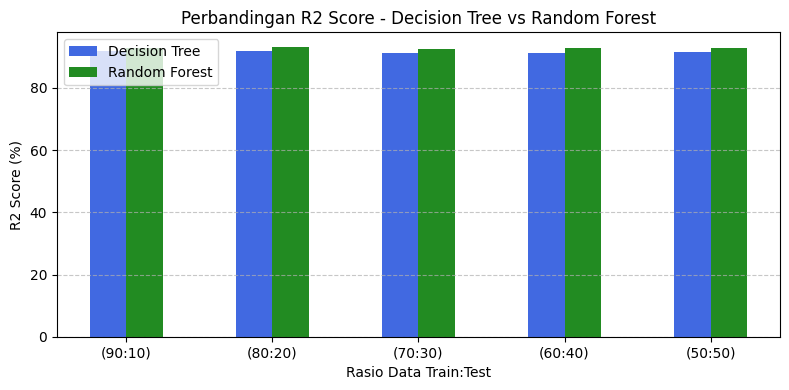

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Label rasio
labels = list(r2_results_dt.keys())
x = np.arange(len(labels))  # posisi bar di sumbu x
width = 0.25  # lebar bar

# Ambil R2 score dari hasil evaluasi
r2_dt = [r2_results_dt[k] for k in labels]
r2_rf = [r2_results_rf[k] for k in labels]

# Buat figure yang sedikit lebih besar
plt.figure(figsize=(8, 4))

# Plot R2 Score Decision Tree
plt.bar(x - width/2, r2_dt, width=width, label='Decision Tree', color='royalblue')

# Plot R2 Score Random Forest
plt.bar(x + width/2, r2_rf, width=width, label='Random Forest', color='forestgreen')

# Label dan legenda
plt.xticks(x, labels)
plt.xlabel('Rasio Data Train:Test')
plt.ylabel('R2 Score (%)')
plt.title('Perbandingan R2 Score - Decision Tree vs Random Forest')

# Legend dan grid
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Layout agar tampilan rapi
plt.tight_layout()
plt.show()

### 19. Komparasi Model

In [25]:
# Mencari R2 Score tertinggi dari Decision Tree dan Random Forest
max_r2_dt = max(r2_results_dt.values())  # R2 terbaik untuk Decision Tree
max_r2_rf = max(r2_results_rf.values())  # R2 terbaik untuk Random Forest
best_r2_dt_ratio = [k for k, v in r2_results_dt.items() if v == max_r2_dt][0]
best_r2_rf_ratio = [k for k, v in r2_results_rf.items() if v == max_r2_rf][0]

# Mencari RMSE Train tertinggi dari kedua model
max_rmse_train_dt = max([results_dt[k]['RMSE_Train'] for k in results_dt])
max_rmse_train_rf = max([results_rf[k]['RMSE_Train'] for k in results_rf])
best_rmse_train_dt_ratio = [k for k, v in results_dt.items() if v['RMSE_Train'] == max_rmse_train_dt][0]
best_rmse_train_rf_ratio = [k for k, v in results_rf.items() if v['RMSE_Train'] == max_rmse_train_rf][0]

# Mencari RMSE Test terendah dari kedua model
min_rmse_test_dt = min([results_dt[k]['RMSE_Test'] for k in results_dt])
min_rmse_test_rf = min([results_rf[k]['RMSE_Test'] for k in results_rf])
best_rmse_test_dt_ratio = [k for k, v in results_dt.items() if v['RMSE_Test'] == min_rmse_test_dt][0]
best_rmse_test_rf_ratio = [k for k, v in results_rf.items() if v['RMSE_Test'] == min_rmse_test_rf][0]

# Menampilkan hasil komparasi
print("Komparasi Model Decision Tree dan Random Forest:")
print("-" * 60)
print(f"R2 Score Tertinggi:")
print(f"  Decision Tree: {best_r2_dt_ratio} dengan R2 = {max_r2_dt}%")
print(f"  Random Forest: {best_r2_rf_ratio} dengan R2 = {max_r2_rf}%")
print("-" * 60)

print(f"RMSE Train Tertinggi:")
print(f"  Decision Tree: {best_rmse_train_dt_ratio} dengan RMSE Train = {max_rmse_train_dt}%")
print(f"  Random Forest: {best_rmse_train_rf_ratio} dengan RMSE Train = {max_rmse_train_rf}%")
print("-" * 60)

print(f"RMSE Test Terendah:")
print(f"  Decision Tree: {best_rmse_test_dt_ratio} dengan RMSE Test = {min_rmse_test_dt}%")
print(f"  Random Forest: {best_rmse_test_rf_ratio} dengan RMSE Test = {min_rmse_test_rf}%")
print("-" * 60)

Komparasi Model Decision Tree dan Random Forest:
------------------------------------------------------------
R2 Score Tertinggi:
  Decision Tree: (80:20) dengan R2 = 91.84%
  Random Forest: (80:20) dengan R2 = 93.21%
------------------------------------------------------------
RMSE Train Tertinggi:
  Decision Tree: (90:10) dengan RMSE Train = 9.58%
  Random Forest: (90:10) dengan RMSE Train = 9.06%
------------------------------------------------------------
RMSE Test Terendah:
  Decision Tree: (80:20) dengan RMSE Test = 11.85%
  Random Forest: (80:20) dengan RMSE Test = 10.81%
------------------------------------------------------------


### 20. Visualisasi Model

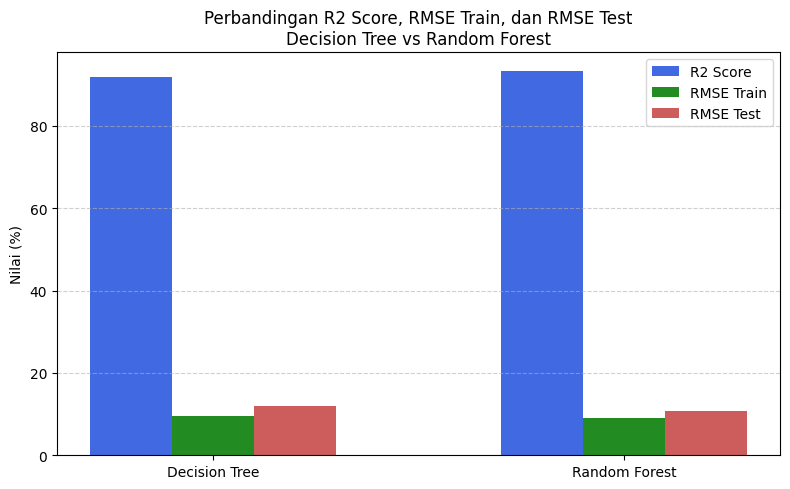

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Nama model dan metrik
models = ['Decision Tree', 'Random Forest']
metrik_labels = ['R2 Score', 'RMSE Train', 'RMSE Test']

# Nilai metrik untuk masing-masing model
dt_values = [91.84, 9.58, 11.85]
rf_values = [93.21, 9.06, 10.81]

x = np.arange(len(models))  # [0, 1] -> untuk dua model
width = 0.20  # Lebar setiap bar

# Buat plot
plt.figure(figsize=(8, 5))

# Plot masing-masing metrik (3 bar per model)
plt.bar(x[0] - width, dt_values[0], width=width, label='R2 Score', color='royalblue')
plt.bar(x[0],           dt_values[1], width=width, label='RMSE Train', color='forestgreen')
plt.bar(x[0] + width, dt_values[2], width=width, label='RMSE Test', color='indianred')

plt.bar(x[1] - width, rf_values[0], width=width, color='royalblue')
plt.bar(x[1],           rf_values[1], width=width, color='forestgreen')
plt.bar(x[1] + width, rf_values[2], width=width, color='indianred')

# Konfigurasi sumbu dan tampilan
plt.xticks(x, models)
plt.ylabel('Nilai (%)')
plt.title('Perbandingan R2 Score, RMSE Train, dan RMSE Test\nDecision Tree vs Random Forest')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 21. Komparasi Error

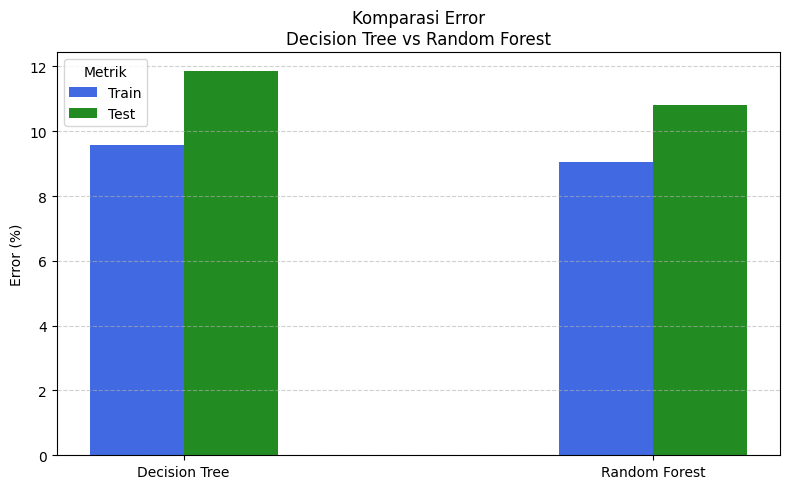

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Nama model dan metrik
models = ['Decision Tree', 'Random Forest']
metrik_labels = ['RMSE Train', 'RMSE Test']

# Nilai metrik untuk masing-masing model
dt_values = [9.58, 11.85]  # RMSE untuk Decision Tree
rf_values = [9.06, 10.81]  # RMSE untuk Random Forest

x = np.arange(len(models))  # [0, 1] -> untuk dua model
width = 0.20  # Lebar setiap bar

# Buat plot
plt.figure(figsize=(8, 5))

# Plot RMSE Train dan RMSE Test untuk masing-masing model
plt.bar(x[0] - width/2, dt_values[0], width=width, label='Train', color='royalblue')
plt.bar(x[0] + width/2, dt_values[1], width=width, label='Test', color='forestgreen')

plt.bar(x[1] - width/2, rf_values[0], width=width, color='royalblue')
plt.bar(x[1] + width/2, rf_values[1], width=width, color='forestgreen')

# Konfigurasi sumbu dan tampilan
plt.xticks(x, models)
plt.ylabel('Error (%)')
plt.title('Komparasi Error\nDecision Tree vs Random Forest')
plt.legend(title='Metrik')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()